## Plots of MOM6 ISOMIP 

Using GFDL ISOMIP/layer configuration, with modifications in `MOM_override` (see each experiments' folder) with `REGRIDDING_COORDINATE_MODE` set to different coordinates.

I tried to make the ISOMIP configuration have minimal velocities with no shelf (`_noshelf`), and then added the shelf back in (`_addshelf`).


In [1]:
#Load required packages
%matplotlib inline
import matplotlib.pyplot as plt
import xarray as xr
from xgcm import Grid
import numpy as np
import cmocean as cm
from dask.distributed import Client


In [2]:
client = Client()
client


Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/8787/status,
Dashboard: /proxy/8787/status,Workers: 4
Total threads: 8,Total memory: 32.00 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:35721,Workers: 4
Dashboard: /proxy/8787/status,Total threads: 8
Started: Just now,Total memory: 32.00 GiB
Comm: tcp://127.0.0.1:36815,Total threads: 2
Dashboard: /proxy/45701/status,Memory: 8.00 GiB
Nanny: tcp://127.0.0.1:37469,


In [3]:
base_folder = '/scratch/x77/cy8964/mom6/archive/'
list_folders = ['zstar-quiet_noshelf','sigma-quiet_noshelf',\
               'zstar-quiet_noshelf_addshelf','sigmazstar-quiet_noshelf_addshelf',\
               'sigma-quiet_noshelf_addshelf']
no_configs = len(list_folders)

In [4]:
## define some useful functions

## open files from NCI storage
def open_files(i):
    base = base_folder + list_folders[i]
    prog = xr.open_dataset(base + '/output000/prog__0001_001.nc')
    ocean_static = xr.open_dataset(base + "/output000/ocean_geometry.nc")
    return prog, ocean_static

## plot a transect of variable with given y section (yy0) and time (tt)
def plot(ax,yy0,tt,i,variable,varname,vmin1,vmax1,cmap):
    prog, ocean_static = open_files(i)
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                             "y":{"center":"yh","outer":"yq"},
                             "z":{"center":"zl","outer":"zi"}},periodic=False)
    file_name = list_folders[i]
    label = list_folders[i]
    depth = grid.interp(prog.e,'x')
    lon = ocean_static.geolonb
    dataplot = variable

    xx = lon
    if varname == "uo": dataplot = dataplot[:,:,:,:-1]
    levels = np.linspace(vmin1, vmax1, 51)
    yy = depth[:,:,yy0,:]
    z_levels = yy.shape[1]
    yi = np.linspace(0,5000,z_levels) #Dummy, just for have z_levels
    # plot variable in colours
    xi, yyi = np.meshgrid(xx[yy0,:], yi) #We repeat the horizontal part of the grid by the number of zlevels
    cax = ax.pcolormesh(xi,yy[tt,...],dataplot[tt,:,yy0,:],vmin = vmin1, vmax = vmax1, cmap = cmap)
    
    plt.colorbar(cax, ax = ax, label = varname)
    
    ## plot interface heights
    i_heights = prog.e # this is 'Interface Height Relative to Mean Sea Level'
    # do for one time
    i_heights = i_heights.isel(Time = tt)
    # take zonal mean
    i_heights = i_heights.isel(yh = yy0)#.mean('xh')

    # plot a line of layer depths, layer by layer
    nz = len(i_heights.zi)
    xh = prog.xh

    for i in range(nz):
        ax.plot(xh,i_heights[i], color = 'k', linewidth = 0.5)
    
    ax.set_ylim(ymin=-720,ymax=0)
    ax.set_ylabel('Depth (m)')
    ax.set_xlabel('x (km)')
    ax.set_title(varname+' , ' +label)
    
# find horizontal speed
def find_speed(prog):
    # interpolate speeds to the same grid
    uo_interp = grid.interp(prog.u,'x',boundary='extend')
    vo_interp = grid.interp(prog.v,'y',boundary='extend')
    horiz_speed = np.sqrt(uo_interp**2+vo_interp**2)
    return horiz_speed


# Plot transect after 30 days

time = 0001-01-31 00:00:00


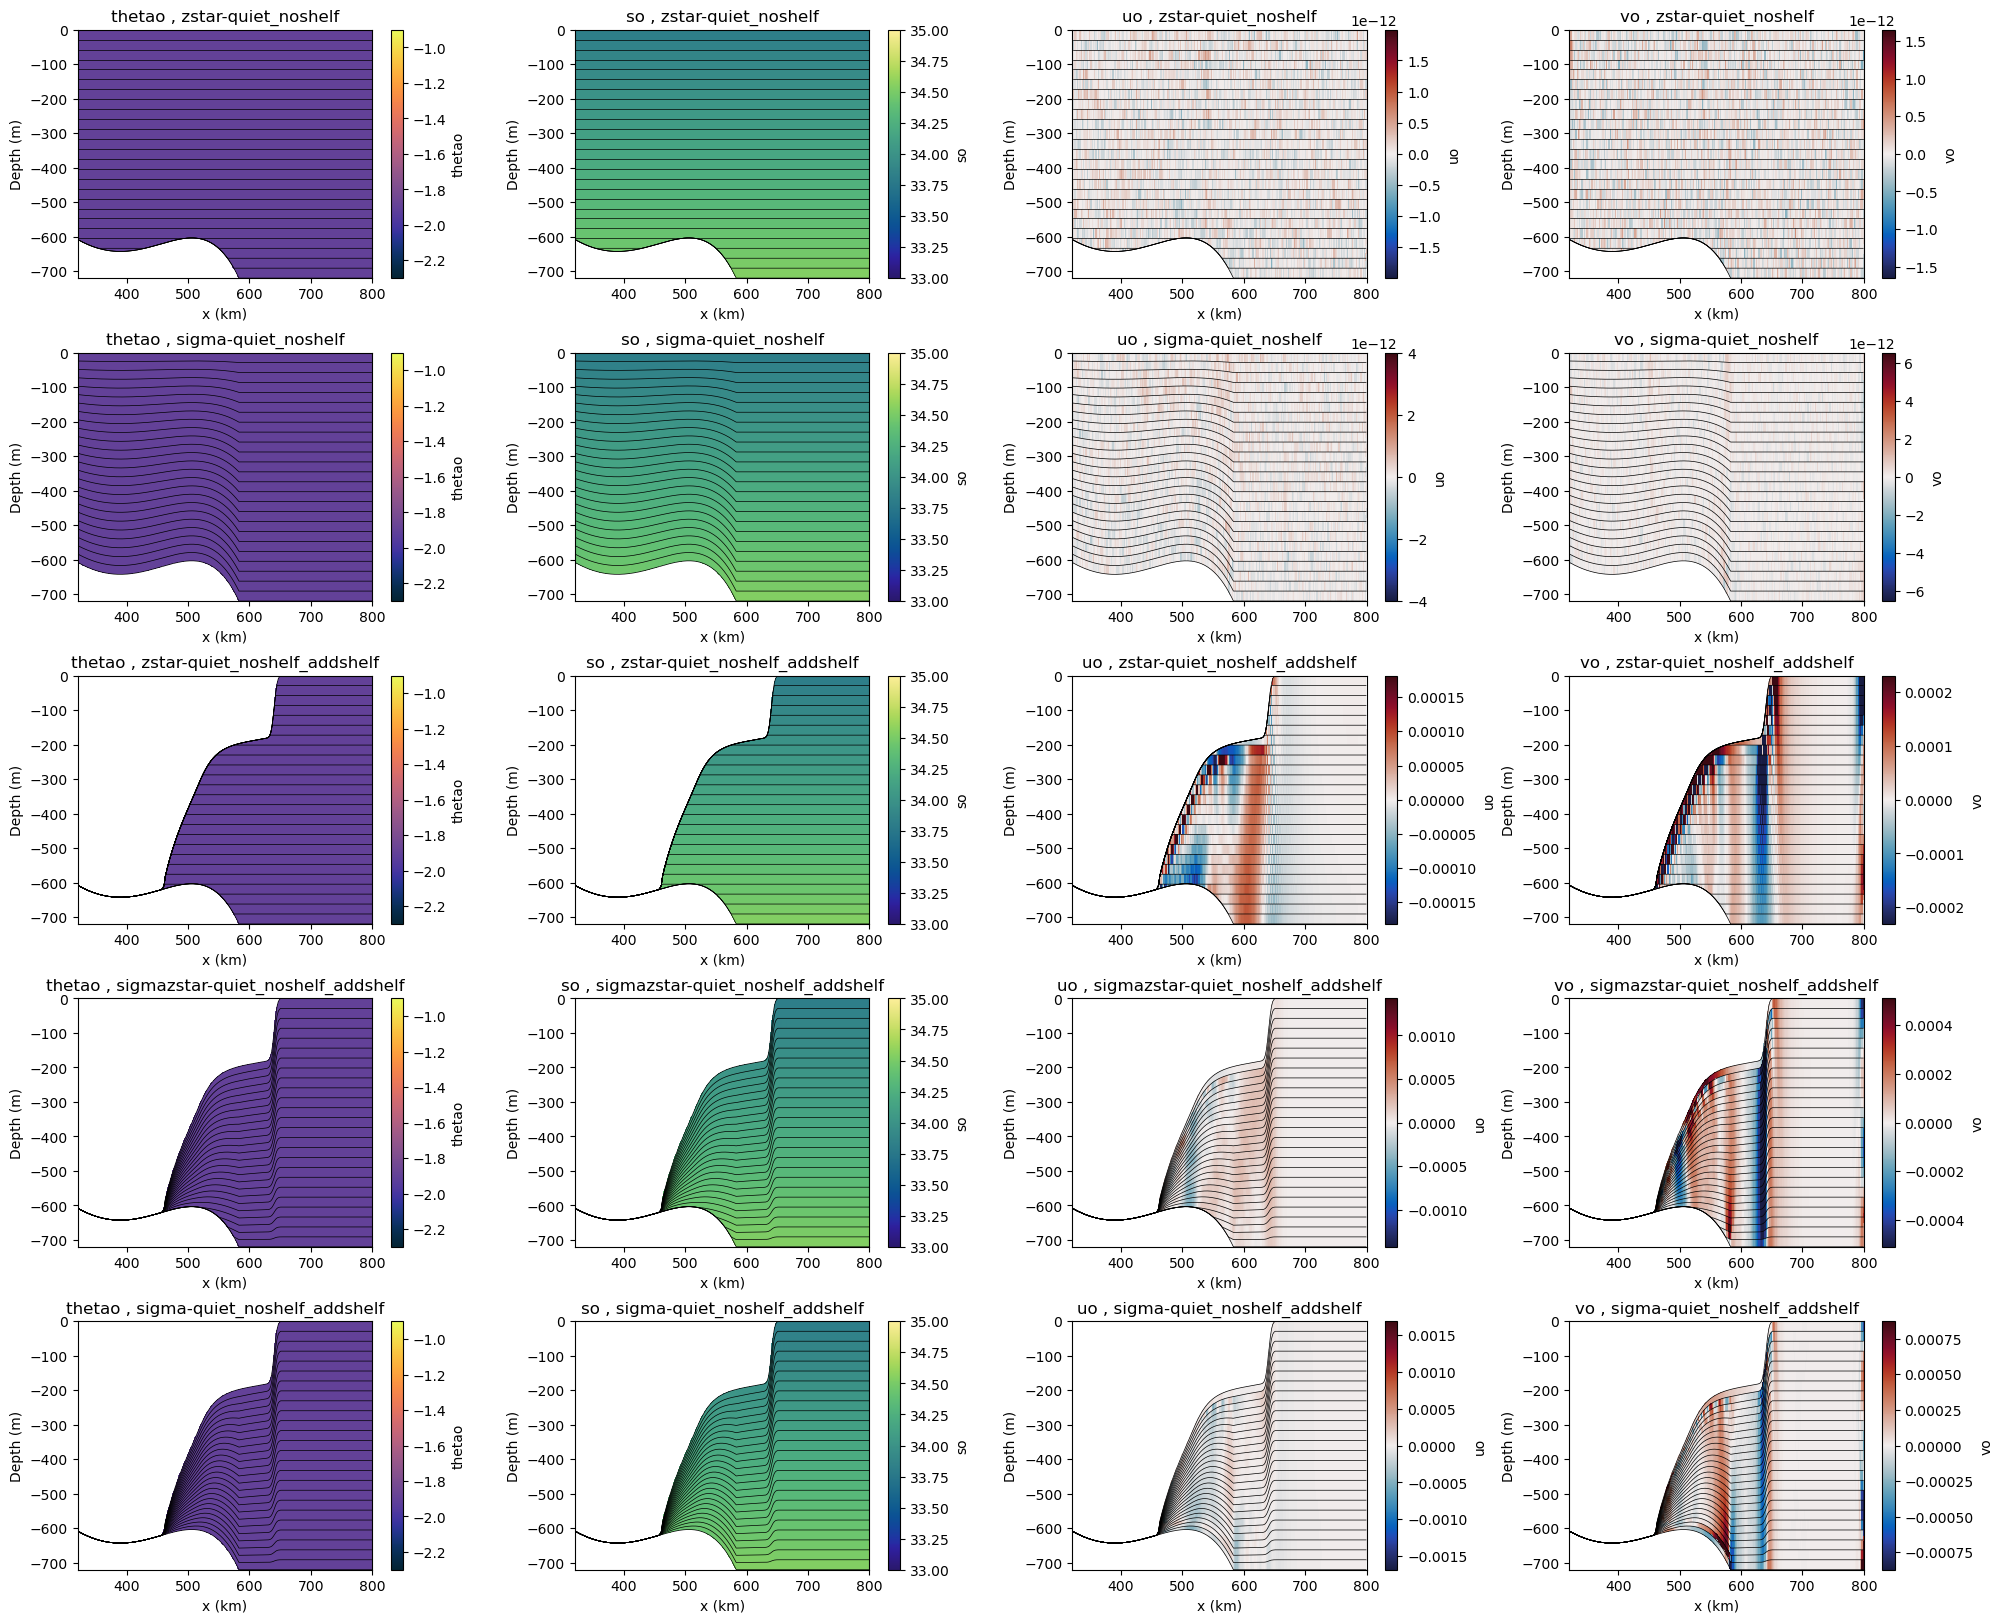

In [9]:
fig,axes = plt.subplots(nrows = no_configs, ncols = 4, figsize = (24,4*no_configs))
time = 359 ## 30 days
x = 25
for j in np.arange(no_configs):
    prog, ocean_static = open_files(j)
    #plot temp
    plot(axes[j,0],x,time,j,prog.temp,"thetao",-2.3,-0.9,cm.cm.thermal)
    # plot salinity
    plot(axes[j,1],x,time,j,prog.salt,"so",33,35,cm.cm.haline)
    # plot u
    scale = np.abs(prog.isel(Time = time).u).max().values
    if scale < 1e-11: ## in case of very small number
        scale = 1e-11
    scale = scale/10
    plot(axes[j,2],x,time,j,prog.u,"uo",-scale,scale,cm.cm.balance)
    # plot v
    scale = np.abs(prog.isel(Time = time).v).max().values
    if scale < 1e-11: ## in case of very small number
        scale = 1e-11
    scale = scale/10
    plot(axes[j,3],x,time,j,prog.v,"vo",-scale,scale,cm.cm.balance)

plt.subplots_adjust(wspace = 0.35, hspace = 0.3)

print('time = '+str(prog.isel(Time = time).Time.values))

# Plot timeseries of maximum horizontal speed

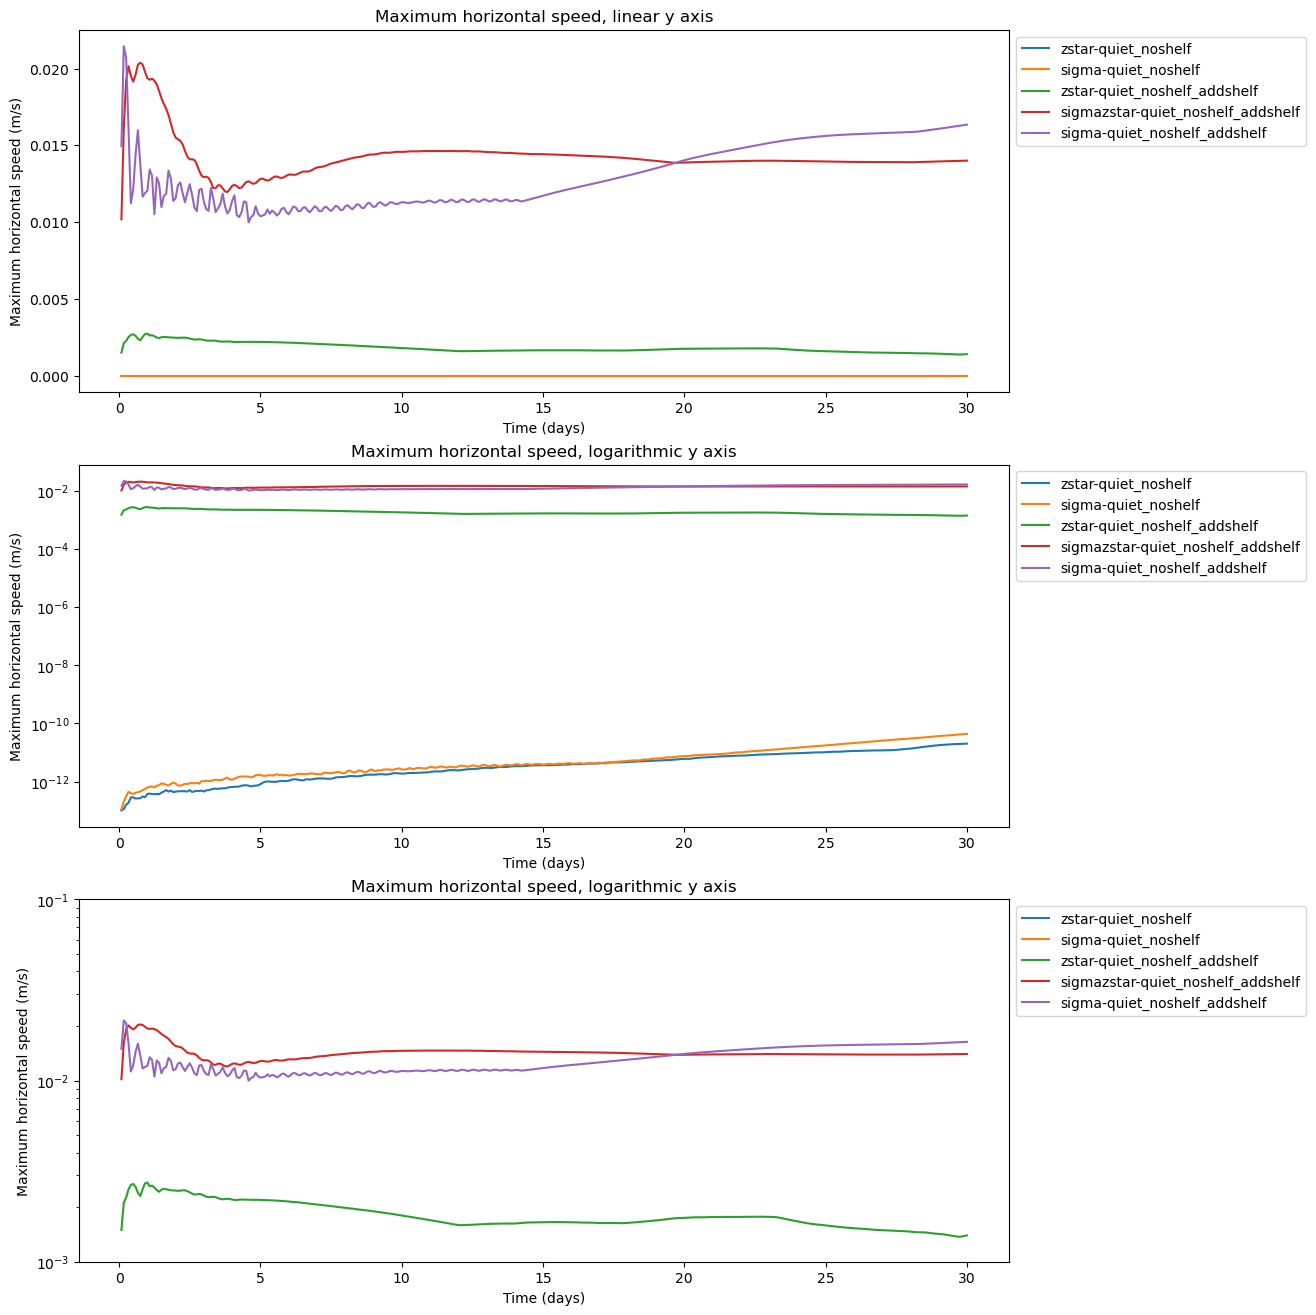

In [10]:
fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (12,16))
linestyle = '-'
for j in np.arange(no_configs):
    prog, ocean_static = open_files(j)
    label = list_folders[j]
    # Generate xgcm grid object:
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                                 "y":{"center":"yh","outer":"yq"},
                                 "z":{"center":"zl","outer":"zi"}},periodic=False)
    if j >= 10:
        linestyle = '--'
    horiz_speed = find_speed(prog)
    Time = (np.arange(len(prog.Time))*2+2)/24
    axes[0].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)
    axes[1].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)
    axes[2].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle)

        
axes[0].set_ylabel('Maximum horizontal speed (m/s)')
axes[0].set_xlabel('Time (days)')
axes[0].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[0].set_title('Maximum horizontal speed, linear y axis')

axes[1].set_yscale('log')
axes[1].set_ylabel('Maximum horizontal speed (m/s)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[1].set_title('Maximum horizontal speed, logarithmic y axis')

axes[2].set_yscale('log')
axes[2].set_ylabel('Maximum horizontal speed (m/s)')
axes[2].set_xlabel('Time (days)')
axes[2].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[2].set_title('Maximum horizontal speed, logarithmic y axis')
axes[2].set_ylim(1e-3,1e-1)

plt.show()


Repeat for rest of first year for no shelf runs

In [ ]:
## open files from NCI storage
def open_files_longrun(i):
    base = base_folder + list_folders[i]
    prog = xr.open_dataset(base + '/output001/prog__0001_031.nc')
    ocean_static = xr.open_dataset(base + "/output000/ocean_geometry.nc")
    return prog, ocean_static

fig, axes = plt.subplots(nrows = 3, ncols = 1, figsize = (12,16))
linestyle = '-'
colors = ['C0','C1','C2','C3']
for j in np.arange(2):
    prog, ocean_static = open_files(j)
    label = list_folders[j]
    # Generate xgcm grid object:
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                                 "y":{"center":"yh","outer":"yq"},
                                 "z":{"center":"zl","outer":"zi"}},periodic=False)
    horiz_speed = find_speed(prog)
    Time = (np.arange(len(prog.Time))*2+2)/24
    axes[0].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle, color = colors[j])
    axes[1].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle, color = colors[j])
    axes[2].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle, color = colors[j])

    prog, ocean_static = open_files_longrun(j)
    label = list_folders[j]
    # Generate xgcm grid object:
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                                 "y":{"center":"yh","outer":"yq"},
                                 "z":{"center":"zl","outer":"zi"}},periodic=False)
    horiz_speed = find_speed(prog)
    Time = (np.arange(len(prog.Time))*2+2)/24+30
    axes[0].plot(Time,horiz_speed.max(['zl','xh','yh']), linestyle = linestyle, color = colors[j])
    axes[1].plot(Time,horiz_speed.max(['zl','xh','yh']), linestyle = linestyle, color = colors[j])
    axes[2].plot(Time,horiz_speed.max(['zl','xh','yh']), linestyle = linestyle, color = colors[j])

## repeat for seamount ones
list_folders_seamount = ['seamount-zstar','seamount-zstar_ISOMIPtopoTSlayerDT']
def open_files_seamount(i):
    base = base_folder + list_folders_seamount[i]
    prog = xr.open_dataset(base + '/output000/prog.nc')
    ocean_static = xr.open_dataset(base + "/output000/ocean_geometry.nc")
    return prog, ocean_static
for j in np.arange(2):
    prog, ocean_static = open_files_seamount(j)
    label = list_folders_seamount[j]
    # Generate xgcm grid object:
    grid = Grid(prog,coords={"x":{"center":"xh","outer":"xq"},
                                 "y":{"center":"yh","outer":"yq"},
                                 "z":{"center":"zl","outer":"zi"}},periodic=False)
    horiz_speed = find_speed(prog)
    Time = (np.arange(len(prog.Time))*2+2)/24
    axes[0].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle, color = colors[j+2])
    axes[1].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle, color = colors[j+2])
    axes[2].plot(Time,horiz_speed.max(['zl','xh','yh']),label = label, linestyle = linestyle, color = colors[j+2])

        
axes[0].set_ylabel('Maximum horizontal speed (m/s)')
axes[0].set_xlabel('Time (days)')
axes[0].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[0].set_title('Maximum horizontal speed, linear y axis')

axes[1].set_yscale('log')
axes[1].set_ylabel('Maximum horizontal speed (m/s)')
axes[1].set_xlabel('Time (days)')
axes[1].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[1].set_title('Maximum horizontal speed, logarithmic y axis')

axes[2].set_yscale('log')
axes[2].set_ylabel('Maximum horizontal speed (m/s)')
axes[2].set_xlabel('Time (days)')
axes[2].legend(bbox_to_anchor = (1,1),loc = 'upper left')
axes[2].set_title('Maximum horizontal speed, logarithmic y axis')
axes[2].set_ylim(1e-3,1e-1)

plt.show()
